# Method 2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import confint_proportions_2indep
from statsmodels.stats.proportion import proportions_ztest
import numpy as np
from math import ceil
import seaborn as sns

df=pd.read_csv(fr"/Users/choyy/Documents/AB_testing/ab_1/ab_data.csv")
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [2]:
# Data cleaning

df.info()
# df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [3]:
df.describe(include='all')

,user_id,timestamp,group,landing_page,converted
count,294478.000000,294478,294478,294478,294478.000000
unique,NaN,294478,2,2,NaN
top,NaN,2017-01-21 22:11:48.556739,treatment,old_page,NaN
freq,NaN,1,147276,147239,NaN
mean,787974.124733,NaN,NaN,NaN,0.119659
std,91210.823776,NaN,NaN,NaN,0.324563
min,630000.000000,NaN,NaN,NaN,0.000000
25%,709032.250000,NaN,NaN,NaN,0.000000
50%,787933.500000,NaN,NaN,NaN,0.000000
75%,866911.750000,NaN,NaN,NaN,0.000000


In [4]:
print("Missing values:\n", df.isna().sum())

Missing values:
 user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64


In [5]:
mismatch_treatment = df.query("group == 'treatment' and landing_page == 'old_page'")
mismatch_control = df.query("group == 'control' and landing_page == 'new_page'")

print("Mismatched rows (treatment != new_page):", mismatch_treatment.shape[0])
print("Mismatched rows (control != old_page):", mismatch_control.shape[0])

Mismatched rows (treatment != new_page): 1965
Mismatched rows (control != old_page): 1928


In [6]:
df_clean = df[(df['group'] == 'treatment') & (df['landing_page'] == 'new_page') |
              (df['group'] == 'control') & (df['landing_page'] == 'old_page')]
df_clean.shape

(290585, 5)

In [7]:

df_clean1=df_clean.copy()
df_clean1['user_id']=df_clean1['user_id'].astype(str)
duplicate=df_clean1.groupby('user_id').agg(count=('user_id','count')).reset_index()
##.squeeze() → Converts the single-column DataFrame into a Pandas Series.
duplicate = duplicate[duplicate['count'] > 1]['user_id'].tolist()


df_clean1=df_clean1[~df_clean1['user_id'].isin(duplicate)]
df_clean1.shape

(290583, 5)

In [8]:
df_group=df_clean1.groupby('group').agg(count=('group','count'))
df_group['proportion']=df_group['count']/df_clean1.shape[0]
df_group



,count,proportion
group,,
control,145274,0.49994
treatment,145309,0.50006


Conversion Rates:
 group
control      0.120386
treatment    0.118809
Name: converted, dtype: float64


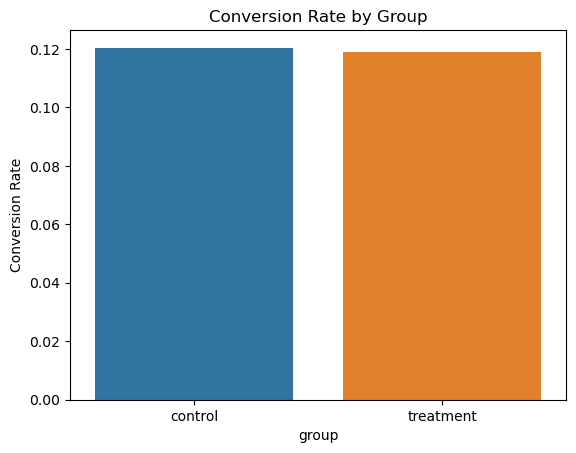

In [9]:
#  EDA

conversion_rates = df_clean1.groupby('group')['converted'].mean()
print("Conversion Rates:\n", conversion_rates)
sns.barplot(x=conversion_rates.index, y=conversion_rates.values)
plt.title("Conversion Rate by Group")
plt.ylabel("Conversion Rate")
plt.show()


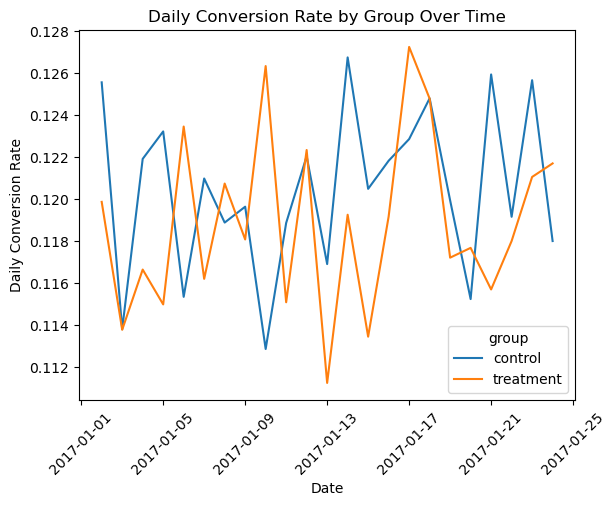

In [10]:
df_clean1['timestamp'] = pd.to_datetime(df_clean['timestamp'])
df_time = df_clean1.set_index('timestamp')
# Resamples the data into daily ('D') intervals.
daily_conversions = df_time.groupby(['group']).resample('D')['converted'].mean().reset_index()

sns.lineplot(x='timestamp', y='converted', hue='group', data=daily_conversions)
plt.title("Daily Conversion Rate by Group Over Time")
plt.ylabel("Daily Conversion Rate")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.show()

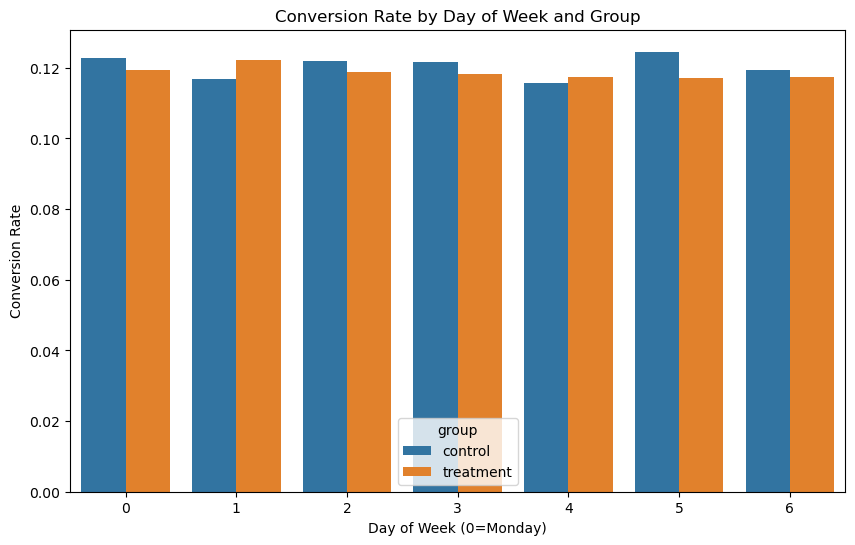

In [11]:
df_clean1['day_of_week'] = df_clean1['timestamp'].dt.dayofweek

dow_conversion = df_clean1.groupby(['day_of_week','group'])['converted'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='day_of_week', y='converted', hue='group', data=dow_conversion)
plt.title("Conversion Rate by Day of Week and Group")
plt.xlabel("Day of Week (0=Monday)")
plt.ylabel("Conversion Rate")
plt.show()

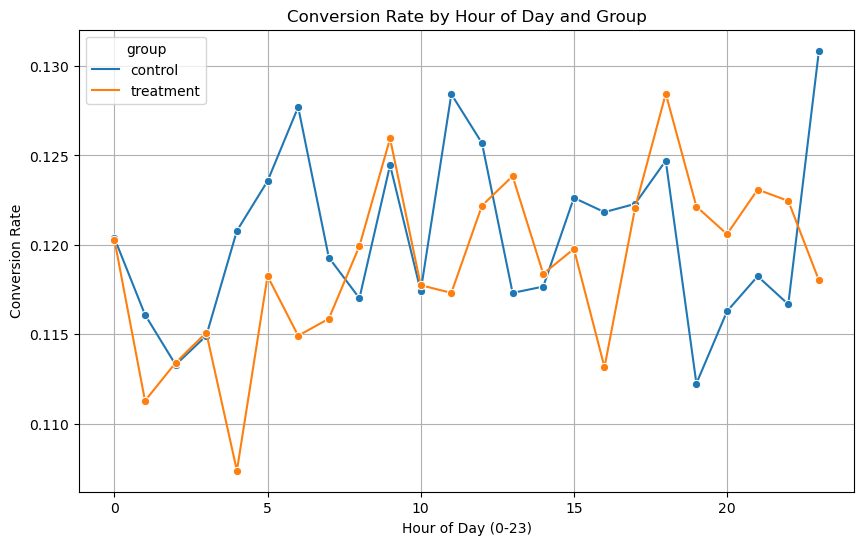

In [12]:
df_clean1['hour_of_day'] = df_clean1['timestamp'].dt.hour
hourly_conversion = df_clean1.groupby(['hour_of_day','group'])['converted'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(x='hour_of_day', y='converted', hue='group', data=hourly_conversion, marker='o')
plt.title("Conversion Rate by Hour of Day and Group")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Conversion Rate")
plt.grid(True)
plt.show()

In [13]:


conv_control = df_clean1.query("group == 'control'")['converted'].sum()
n_control = df_clean1.query("group == 'control'").shape[0]

conv_treatment = df_clean1.query("group == 'treatment'")['converted'].sum()
n_treatment = df_clean1.query("group == 'treatment'").shape[0]

count = np.array([conv_treatment, conv_control])
nobs = np.array([n_treatment, n_control])

# alternative='two-sided': Tests if the two proportions are different (not just greater or smaller).

# conv_treatment, n_treatment: Number of successes & total observations in the treatment group.
# conv_control, n_control: Number of successes & total observations in the control group.
# method='wald': Uses the Wald method, a common approach for confidence intervals in proportion testing.
z_stat, p_val = proportions_ztest(count, nobs, alternative='two-sided')
ci_low, ci_high = confint_proportions_2indep(conv_treatment, n_treatment,
                                             conv_control, n_control, method='wald')

print("Z-statistic:", z_stat)
print("P-value:", p_val)
print("95% CI for difference (treatment - control):", (ci_low, ci_high))

Z-statistic: -1.3102408579271012
P-value: 0.19011436776805024
95% CI for difference (treatment - control): (-0.003937050149335995, 0.0007822074257948881)


In [16]:
nobs

array([145309, 145274])

In [15]:
count

array([17264, 17489], dtype=int64)